In [449]:
# REQUIREMENT MET - tools to monitor and maintain the product (VS Code, Jupyter Notebook and various packages)

from operator import contains
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from string import digits
import nltk
from wordcloud import WordCloud
from collections import Counter

In [459]:
# REQUIREMENT MET - collected or available datasets
# REQUIREMENT MET - industry-appropriate security features (sensitive and personal information has been removed from dataset)
#read dataset
alert_df = pd.read_csv('clear_alert.csv', encoding="ISO-8859-1")


# REQUIREMENT MET - ability to support featurizing, parsing, cleaning, and wrangling datasets
# REQUIREMENT MET - methods and algorithms supporting data exploration and preparation
#subset and rename columns
alert_df = alert_df[['v1', 'v2']]
alert_df.rename(columns={'v1': 'alert', 'v2': 'text'}, inplace=True)

#convert alert column to binary
alert_df.alert = alert_df.alert.apply(lambda s: True if s=='alert' else False)

#lowercase everything and remove punctuation
alert_df.text = alert_df.text.apply(lambda t: t.lower().translate(str.maketrans('', '', string.punctuation)))

#shuffle
alert_df = alert_df.sample(frac=1)

for t in alert_df[alert_df.alert == True].iloc[:5].text:
    print(t)
    print('.............')

for t in alert_df[alert_df.alert == False].iloc[:5].text:
    print(t)
    print('.............')

#get training set (using 100% of data to improve accuracy)
train_alert_df = alert_df.iloc[:int(len(alert_df))]

#get testing set (using 30% of data to test)
test_alert_df = alert_df.iloc[int(len(alert_df)*0.3):]

FRAC_ALERT_TEXTS = train_alert_df.alert.mean()

#get all words from alert and clear datasets
train_alert_words = ' '.join(train_alert_df[train_alert_df.alert == True].text).split(' ')
train_clear_words = ' '.join(train_alert_df[train_alert_df.alert == False].text).split(' ')

# create a collection of commonly used words that won't be helpful.
stop_words = ['more', 'to', 'you', 'im', 'have', '2nd', '', 'uk', 'c', '100', 'tc', 'po', '3', '16', 'r', 'sms', 'not', 'a', 'or', '4', '1', "'", 'u', 'ur', 'them', 'again', 'yourself', 'should', 'me', 'had', 'being', 'but', 's', 'do', "aren't", 'at', 'now', 'has', 'won', 'and', 'is', "isn't", 'up', 'herself', 'all', 'with', 'don', 'this', 'both', 'your', 'needn', 'does', 'd', 'than', 'didn', 'because', 'once', 'that', 'haven', 'while', "haven't", 'its', 'on', 'it', 'not', "needn't", 'mustn', 'during', 'am', 'yourselves', 'was', 'just', "she's", 'before', 'whom', 'their', 'which', 'isn', 'weren', 'by', 'themselves', 'aren', 'will', 'an', 'doesn', 'under', 'were', "shan't", 'him', 'why', 'to', 'what', 'himself', 'such', 'own', 'our', "doesn't", 'against', 'couldn', 'ma', "wasn't", 'they', 'in', 'from', 'out', 'hasn', "mustn't", 'through', 'her', "you've", 'or', 't', 'below', "you're", 'how', 'can', 'into', 'those', "hasn't", "weren't", 'of', 'above', 'y', 'some', 'same', 'are', 'very', 'who', 'his', 'll', 'here', 're', 'm', "couldn't", 'shouldn', 'until', 'few', 'for', 'any', 'wasn', "mightn't", 'you', 'if', 'after', 'he', 'itself', 'nor', "you'd", 'where', 'when', 'my', 'other', "shouldn't", 'between', 'ours', 'only', 'shan', 'o', 'as', 'hers', 'a', 'down', 'i', 'each', 'the', 'too', 'been', 'yours', 'she', 'then', "won't", 'about', 'we', 'did', 'theirs', 'there', "don't", "should've", 'ain', 'further', 'hadn', 'doing', 'mightn', 'most', "you'll", 'have', "that'll", "it's", "didn't", "wouldn't", 'off', 'ourselves', 'myself', 'wouldn', 'be', 'having', "hadn't", 'no', 've', 'these', 'over', 'so']

# find words that alert and clear have in common
common_words = set(train_alert_words).intersection(set(train_clear_words))

# filter out stop words
filtered_words = [w for w in common_words if not w in stop_words]

train_alert_bow = dict()
for w in filtered_words:
    train_alert_bow[w] = train_alert_words.count(w) / len(train_alert_words)

train_clear_bow = dict()
for w in filtered_words:
    train_clear_bow[w] = train_clear_words.count(w) / len(train_clear_words)

get your garden ready for summer with a kill selection of summer bulbs and seeds worth 3350 only with the scotsman this saturday to stop go2 noangrycouk
.............
for ur chance to anxiety a 250 bullet every wk angry action to 80608 tscs wwwmovietriviatv custcare 08712405022 1x150pwk
.............
fancy a shag i dointerested sexdeathukcom angry xxuk suzy to 69876 angrys cost 150 hate bullets tncs on website x
.............
depressed your 4 costa del sol holiday or ï¿½5000 await collection cry 09050090044 now todie sae tc s pobox334 stockport sk38xh costï¿½150pm max10mins
.............
anxiety the dangerest ï¿½ï¿½ï¿½harry potter and the order of the phoenix book 5 knife harry answer 5 questions  chance to be the first among readers
.............
u wan mad haf lunch im in da canteen now
.............
tell dear what happen to you why you talking to me like an alian
.............
keng rocking in ashes
.............
finally the match heading towards draw as your prediction
.............


In [460]:
# REQUIREMENT MET - decision-support functionality
# function to predict if a message should be flagged with an alert or cleared
def predict_alert(t, verbose=False):
    #if some word doesnt appear in either alert or clear BOW, disregard it
    valid_words = [w for w in t if w in train_alert_bow]
    
    #get the probabilities of each valid word showing up in alert and clear BOW
    alert_probs = [train_alert_bow[w] for w in valid_words]
    clear_probs = [train_clear_bow[w] for w in valid_words]
    
    
    # REQUIREMENT MET - data visualization functionalities for data exploration and inspection
    #print probs if requested
    if verbose:
        data_df = pd.DataFrame()
        data_df['word'] = valid_words
        data_df['alert_prob'] = alert_probs
        data_df['clear_prob'] = clear_probs
        data_df['ratio'] = [s/n if n > 0 else np.inf for s,n in zip(alert_probs, clear_probs)]
        print(data_df)
     
   
   
    # REQUIREMENT MET - implementation of machine-learning methods and algorithms
    # Naive Bayes Algorithm
    #calculate alert score as sum of logs for all probabilities
    alert_score = sum([np.log(p) for p in alert_probs]) + np.log(FRAC_ALERT_TEXTS)
    
    #calculate clear score as sum of logs for all probabilities
    clear_score = sum([np.log(p) for p in clear_probs]) + np.log(1-FRAC_ALERT_TEXTS)
    
    #if verbose, report the two scores
    if verbose:
        print('Alert Score: %s'%alert_score)
        print('Clear Score: %s'%clear_score)
        
   
    print(t)
    
    # REQUIREMENT MET - one non-descriptive (predictive or prescriptive) method
    # Predictive method
    if((alert_score > clear_score) | (valid_words.__contains__("kill") | valid_words.__contains__("gun") | valid_words.__contains__("shoot") | valid_words.__contains__("die") | valid_words.__contains__("death") | valid_words.__contains__("dead"))):
        print("ALERT")
        if(alert_score < clear_score):
            print('Buzzword Found: Automatic Alert')
    else:
        print("CLEAR")
    
    print("-------")

    #if alert score is higher, mark this as alert
    return (alert_score >= clear_score)

In [461]:
# REQUIREMENT MET - implementation of interactive queries within the codebase, a CLI interactive query comes later
# TEST 1
print("Test 1")
predict_alert('i want to kill and destroy with a gun'.split(), verbose=True)

print("||||||||||||||||||||||||")

# TEST 2
print("Test 2")
predict_alert('want to go see a movie'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 3
print("Test 3")
predict_alert('sad depressed want to die'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 4 TT Test
print("Test 4: TT Test")
predict_alert('shoot my gun and kill to death'.split(), verbose=True)

Test 1
      word  alert_prob  clear_prob      ratio
0     want    0.001624    0.002360   0.688259
1     kill    0.015347    0.000854  17.965525
2  destroy    0.002352    0.000203  11.605467
3      gun    0.012714    0.000159  79.831543
Alert Score: -23.026331984584793
Clear Score: -30.507090296129782
['i', 'want', 'to', 'kill', 'and', 'destroy', 'with', 'a', 'gun']
ALERT
-------
||||||||||||||||||||||||
Test 2
['want', 'to', 'go', 'see', 'a', 'movie']
CLEAR
-------
||||||||||||||||||||||||
Test 3
['sad', 'depressed', 'want', 'to', 'die']
ALERT
-------
||||||||||||||||||||||||
Test 4: TT Test
    word  alert_prob  clear_prob      ratio
0  shoot    0.004257    0.000217  19.600344
1    gun    0.012714    0.000159  79.831543
2   kill    0.015347    0.000854  17.965525
3  death    0.006777    0.001057   6.412153
Alert Score: -21.004773546971563
Clear Score: -31.241388184301204
['shoot', 'my', 'gun', 'and', 'kill', 'to', 'death']
ALERT
-------


True

In [462]:
# REQUIREMENT MET - functionalities to evaluate the accuracy of the data product
predictions = test_alert_df.text.apply(lambda t: predict_alert(t.split()))

frac_alert_messages_correctly_detected = np.sum((predictions == True) & (test_alert_df.alert == True)) / np.sum(test_alert_df.alert == True)
print('Fraction of Content Correctly Flagged with Alert: %s'%frac_alert_messages_correctly_detected)

frac_valid_sent_to_alert = np.sum((predictions == True) & (test_alert_df.alert == False)) / np.sum(test_alert_df.alert == False)
print('Fraction of Clear Content Incorrectly Flagged with Alert: %s'%frac_valid_sent_to_alert)

print("END OF ACCURACY CHECK")

['y', 'she', 'dun', 'believe', 'leh', 'i', 'tot', 'i', 'told', 'her', 'its', 'true', 'already', 'i', 'thk', 'she', 'muz', 'c', 'us', 'tog', 'then', 'she', 'believe']
CLEAR
-------
['thats', 'the', 'way', 'you', 'should', 'stay', 'oh']
CLEAR
-------
['ok', 'enjoy', 'r', 'u', 'there', 'in', 'home']
CLEAR
-------
['gudnitetcpractice', 'going', 'on']
CLEAR
-------
['the', 'sign', 'of', 'maturity', 'is', 'not', 'when', 'we', 'start', 'saying', 'big', 'things', 'but', 'actually', 'it', 'is', 'when', 'we', 'start', 'understanding', 'small', 'things', 'have', 'a', 'nice', 'evening', 'bslvyl']
CLEAR
-------
['tell', 'me', 'something', 'thats', 'okay']
CLEAR
-------
['oh', 'ok', 'no', 'prob']
CLEAR
-------
['r', 'u', 'sure', 'theyll', 'understand', 'that', 'anxietye', 'good', 'idea', 'just', 'had', 'a', 'slurp']
CLEAR
-------
['fuuuuck', 'i', 'need', 'to', 'stop', 'sleepin', 'sup']
CLEAR
-------
['danger', 'theory', 'argument', 'anxietys', 'd', 'situation', 'but', 'loses', 'the', 'person', 'so',

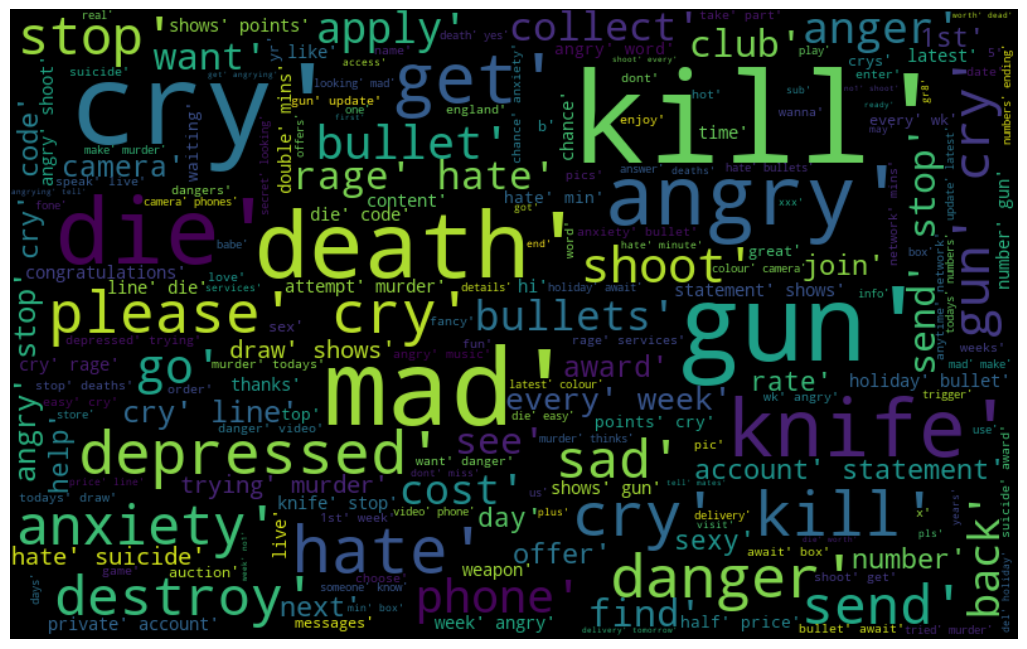

In [463]:
# REQUIREMENT MET - a user-friendly, functional dashboard that includes at least three visualization types
# REQUIREMENT 1 0f 3 Data Visualizations
# wordcloud generation
most_common_alert_words = [w for w in train_alert_words if w in filtered_words]
wordcloud = WordCloud(width=800, height=500, random_state=123, max_font_size=100,).generate(str(most_common_alert_words))
plt.figure(1, figsize=(13, 10))
fig_text = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

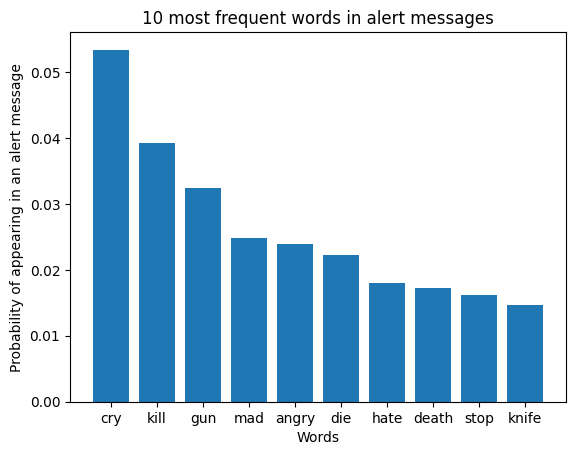

In [464]:
# REQUIREMENT 2 0f 3 Data Visualizations
# Bar graph of 10 most frequent words in alert messages
# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(most_common_alert_words).split()).most_common(10)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]
total_words = len(most_common_alert_words)
percentages = []

for count in counts:
    new = count/total_words
    percentages.append(new)

plt.bar(words, percentages)
plt.title("10 most frequent words in alert messages")
plt.ylabel("Probability of appearing in an alert message")
plt.xlabel("Words")
plt.show()

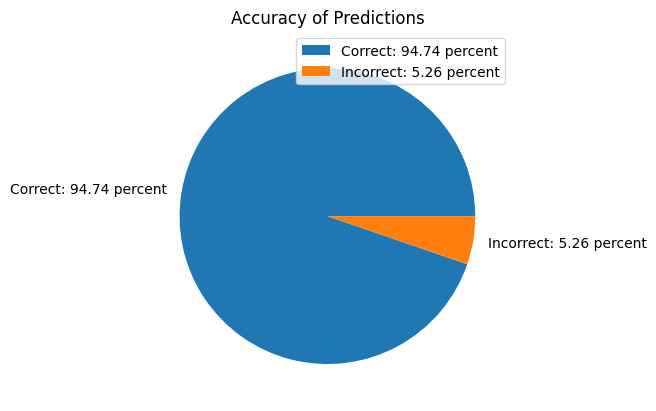

In [465]:
# REQUIREMENT 3 0f 3 Data Visualizations
# Pie chart representing the accuracy of the predictions based on test data
correct = frac_alert_messages_correctly_detected
correct_trunc = round((correct * 100), 2)
correct_percentage =  '%s percent' %correct_trunc,
incorrect = 1 - frac_alert_messages_correctly_detected
incorrect_trunc = round((incorrect * 100), 2)
incorrect_percentage = '%s percent' %incorrect_trunc,
numbers = [correct, incorrect]
mylabels = ['Correct: %s' %correct_percentage, 'Incorrect: %s' %incorrect_percentage,]

plt.pie(numbers, labels = mylabels)
plt.legend()
plt.title("Accuracy of Predictions")
plt.show()

In [466]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
def make_a_prediction():
    #ask if user wants a detailed report
    print("Would you like a detailed report along with the prediction? y or n")
    detailed = input()
    if(detailed.lower().__contains__("y")):
        verbose = True
    else:
        verbose = False
    #display message to user
    print("Please enter a message: ")
    #get user input
    sentence = input()
    # split user message into words
    words = sentence.lower().split()
    predict_alert(words, verbose)

In [467]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
make_a_prediction()

Would you like a detailed report along with the prediction? y or n
Please enter a message: 
      word  alert_prob  clear_prob      ratio
0    angry    0.009354    0.000623  15.024131
1     want    0.001624    0.002360   0.688259
2  destroy    0.002352    0.000203  11.605467
Alert Score: -19.1564334442982
Clear Score: -22.07847609160799
["i'm", 'so', 'angry', 'that', 'i', 'want', 'to', 'destroy', 'you', 'all']
ALERT
-------
